# Calculating spectral indices

https://gisgeography.com/sentinel-2-bands-combinations/

https://github.com/awesome-spectral-indices/awesome-spectral-indices

![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41597-023-02096-0/MediaObjects/41597_2023_2096_Fig6_HTML.png)

In [10]:
import pyproj
import pystac_client
import stackstac
import xarray as xr
from shapely.geometry import box
from shapely.ops import transform



In [1]:
# STAC connection information for Sentinel 2 COGs
STAC_URL = "https://earth-search.aws.element84.com/v0"
STAC_COLLECTION = "sentinel-s2-l2a-cogs"

# a few more parameters
RESOLUTION = 20  # meters
BANDS = ["B04", "B03", "B02", "B08"]
START_DATE = "2022-05-01"
END_DATE = "2022-06-30"

In [2]:
import geopandas as gpd

In [4]:
df = gpd.read_file('./datos/geo/olite.geojson')

In [5]:
EPSG = df.crs.to_epsg()
EPSG

4326

In [6]:
AOI = df.geometry[0]

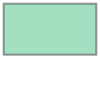

In [7]:
AOI

In [8]:
AOI.bounds

(-1.8765527010048686,
 42.37703618080579,
 -1.5116776445450455,
 42.57788464943084)

In [48]:
# STAC items store bounding box info in epsg:4326
transformer_5070 = pyproj.Transformer.from_crs(
    crs_from="epsg:4326",
    crs_to="epsg:5070",
    always_xy=True,
)

bbox_5070 = transform(transformer_5070.transform, AOI).bounds
bbox_5070

(6483863.32592184, 5665178.739055963, 6518963.114918458, 5702416.66651025)

In [11]:
catalog = pystac_client.Client.open(STAC_URL)

stac_items = catalog.search(
    collections=[STAC_COLLECTION],
    bbox=AOI.bounds,
    datetime=[START_DATE, END_DATE],
).get_all_items()

In [12]:
stac_items

In [13]:
len(stac_items)

48

In [15]:
sentinel_stack = stackstac.stack(
    items=stac_items,
    assets=BANDS,
    epsg=5070,
    resolution=RESOLUTION,
    bounds=AOI.bounds,
    xy_coords="center",
)
sentinel_stack

/home/alabarga/BSC/code/environments/siglibre/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-534953ddc30eb9aa65d6fb26b6a7999a' (time: 0,
                                                                band: 0, y: 1,
                                                                x: 1)>
dask.array<fetch_raster_window, shape=(0, 0, 1, 1), dtype=float64, chunksize=(0, 0, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 
    id       (time) float64 
  * band     (band) float64 
  * x        (x) float64 -10.0
  * y        (y) float64 50.0
    epsg     int64 5070
Attributes:
    spec:        RasterSpec(epsg=5070, bounds=(-20, 40, 0, 60), resolutions_x...
    crs:         epsg:5070
    transform:   | 20.00, 0.00,-20.00|\n| 0.00,-20.00, 60.00|\n| 0.00, 0.00, ...
    resolution:  20

In [16]:
def flatten(x, dim="time"):
    assert isinstance(x, xr.DataArray)
    if len(x[dim].values) > len(set(x[dim].values)):
        x = x.groupby(dim).map(stackstac.mosaic)

    return x


# round time coordinates so all observations from the same day so they have
# equivalent timestamps
sentinel_stack = sentinel_stack.assign_coords(
    time=sentinel_stack.time.astype("datetime64[D]")
)

# mosaic along time dimension
flat_stack = flatten(sentinel_stack, dim="time")
flat_stack

/tmp/ipykernel_25669/1844268677.py:12: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time=sentinel_stack.time.astype("datetime64[D]")


<xarray.DataArray 'stackstac-534953ddc30eb9aa65d6fb26b6a7999a' (time: 0,
                                                                band: 0, y: 1,
                                                                x: 1)>
dask.array<fetch_raster_window, shape=(0, 0, 1, 1), dtype=float64, chunksize=(0, 0, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 
    id       (time) float64 
  * band     (band) float64 
  * x        (x) float64 -10.0
  * y        (y) float64 50.0
    epsg     int64 5070
Attributes:
    spec:        RasterSpec(epsg=5070, bounds=(-20, 40, 0, 60), resolutions_x...
    crs:         epsg:5070
    transform:   | 20.00, 0.00,-20.00|\n| 0.00,-20.00, 60.00|\n| 0.00, 0.00, ...
    resolution:  20

In [51]:
%%time 
flat_stack = flat_stack.compute()

CPU times: user 43.6 s, sys: 6.48 s, total: 50.1 s
Wall time: 5min 57s


In [78]:
len(flat_stack)

11

/home/alabarga/BSC/code/environments/siglibre/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


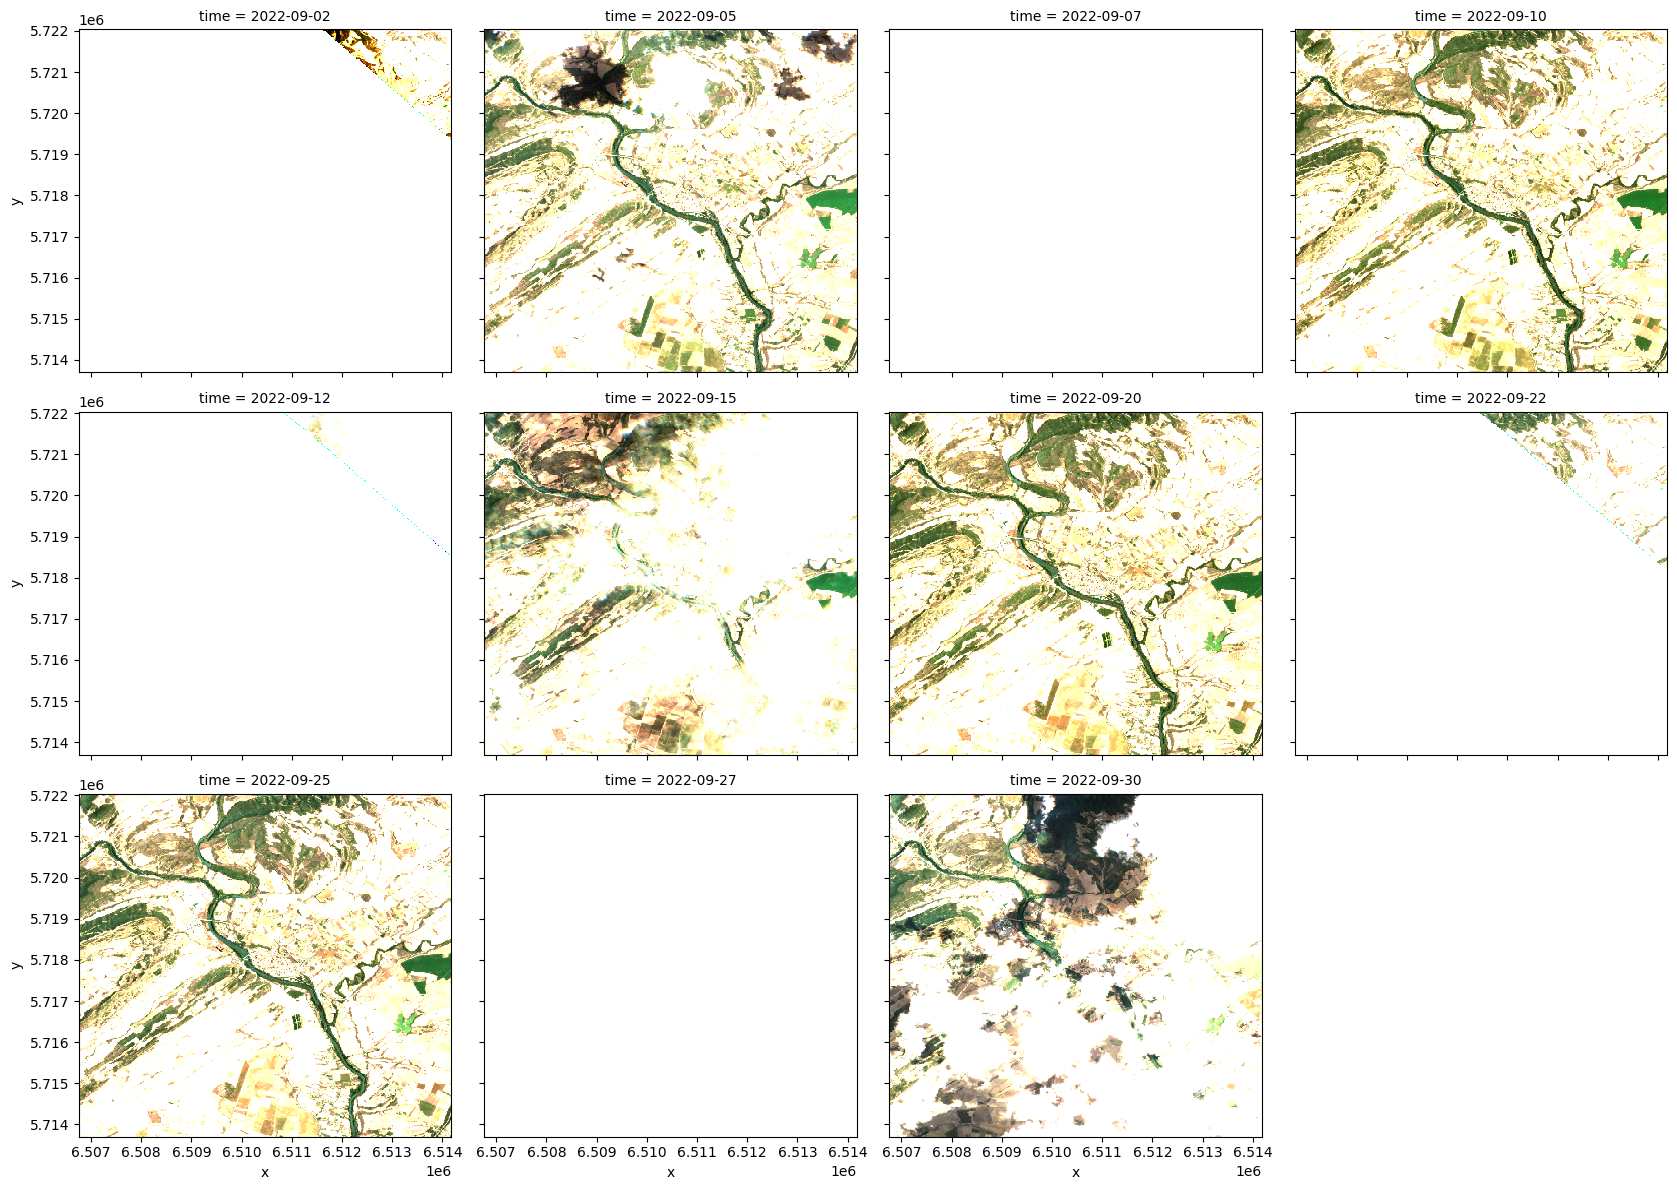

In [34]:
flat_stack.sel(band=["B04", "B03", "B02"]).plot.imshow(
    col="time",
    col_wrap=4,
    rgb="band",
    robust=True,
    size=4,
    vmin=0,
    vmax=1000,
    add_labels=False,
)

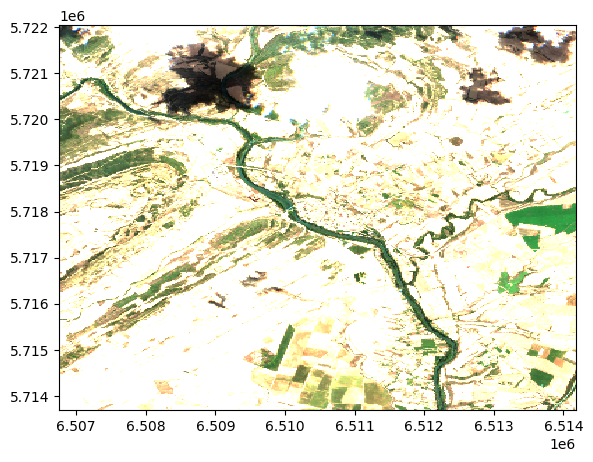

In [33]:
flat_stack.sel(band=["B04", "B03", "B02"], time="2022-09-05").plot.imshow(
    rgb="band",
    robust=True,
    size=5,
    vmin=0,
    vmax=1000,
    add_labels=False,
)

In [17]:
R, G, B, NIR = flat_stack.sel(band=["B04", "B03", "B02", "B08"], time="2022-09-05")

ValueError: could not convert string to float: 'B04'

In [82]:
NDVI = (NIR - R) / (NIR + R)

In [84]:
R

<xarray.DataArray 'stackstac-d70ebc6a77f2cc2f7e8d58ea927b5563' (y: 417, x: 371)>
array([[ 278.,  219.,  174., ..., 2844., 2492., 2020.],
       [ 168.,  348.,  149., ..., 2604., 2522., 2334.],
       [ 286.,  306.,  143., ..., 2718., 2142., 2318.],
       ...,
       [2050., 2044., 2336., ..., 1604., 1056., 2280.],
       [1906., 2250., 2400., ..., 1554.,  874., 1338.],
       [1904., 2094., 2294., ..., 2018.,  670., 1012.]])
Coordinates: (12/30)
    time                          datetime64[ns] 2022-09-05
    id                            <U24 'S2B_30TXN_20220905_0_L2A'
    band                          <U3 'B04'
  * x                             (x) float64 6.507e+06 6.507e+06 ... 6.514e+06
  * y                             (y) float64 5.722e+06 5.722e+06 ... 5.714e+06
    sentinel:sequence             <U1 '0'
    ...                            ...
    title                         <U14 'Band 4 (red)'
    proj:transform                object {0, 4800000, 600000, 1, 10, -10}
    common_name                   <U5 'red'
    center_wavelength             float64 0.6645
    full_width_half_max           float64 0.038
    epsg                          int64 5070
Attributes:
    spec:        RasterSpec(epsg=5070, bounds=(6506760, 5713700, 6514180, 572...
    crs:         epsg:5070
    transform:   | 20.00, 0.00, 6506760.00|\n| 0.00,-20.00, 5722040.00|\n| 0....
    resolution:  20

In [83]:
NDVI

<xarray.DataArray 'stackstac-d70ebc6a77f2cc2f7e8d58ea927b5563' (y: 417, x: 371)>
array([[0.33492823, 0.35588235, 0.42096506, ..., 0.11013767, 0.12867133,
        0.15973378],
       [0.54285714, 0.18501171, 0.46402878, ..., 0.14901961, 0.13659706,
        0.14285714],
       [0.318236  , 0.18291055, 0.47905282, ..., 0.14245149, 0.15168317,
        0.13732787],
       ...,
       [0.17071197, 0.17580645, 0.14930808, ..., 0.21488008, 0.47384155,
        0.18745545],
       [0.20050336, 0.17370547, 0.14529915, ..., 0.24305894, 0.40218878,
        0.37359551],
       [0.2503937 , 0.15937375, 0.15630747, ..., 0.18988358, 0.44490472,
        0.4841998 ]])
Coordinates: (12/25)
    time                          datetime64[ns] 2022-09-05
    id                            <U24 'S2B_30TXN_20220905_0_L2A'
  * x                             (x) float64 6.507e+06 6.507e+06 ... 6.514e+06
  * y                             (y) float64 5.722e+06 5.722e+06 ... 5.714e+06
    sentinel:sequence             <U1 '0'
    instruments                   <U3 'msi'
    ...                            ...
    sentinel:product_id           <U60 'S2B_MSIL2A_20220905T105619_N0400_R094...
    updated                       <U24 '2022-09-05T15:50:57.280Z'
    constellation                 <U10 'sentinel-2'
    proj:shape                    object {10980}
    proj:transform                object {0, 4800000, 600000, 1, 10, -10}
    epsg                          int64 5070

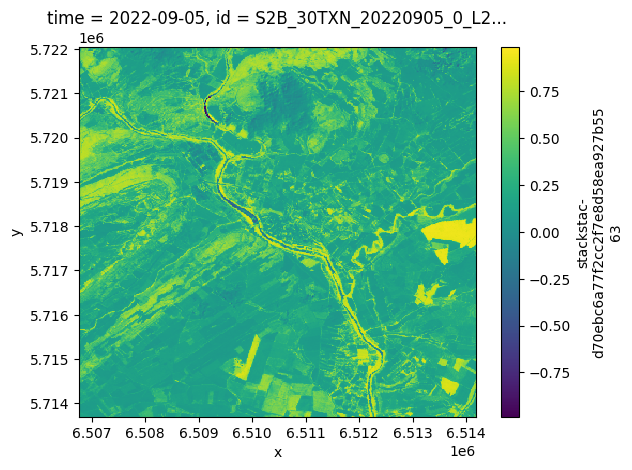

In [87]:
NDVI.plot.imshow(cmap="viridis")

## Using spyndex

In [18]:
import spyndex

In [19]:
# All indices
spyndex.indices

SpectralIndices(['AFRI1600', 'AFRI2100', 'ANDWI', 'ARI', 'ARI2', 'ARVI', 'ATSAVI', 'AVI', 'AWEInsh', 'AWEIsh', 'BAI', 'BAIM', 'BAIS2', 'BCC', 'BI', 'BITM', 'BIXS', 'BLFEI', 'BNDVI', 'BRBA', 'BWDRVI', 'BaI', 'CCI', 'CIG', 'CIRE', 'CSI', 'CSIT', 'CVI', 'DBI', 'DBSI', 'DPDD', 'DSI', 'DSWI1', 'DSWI2', 'DSWI3', 'DSWI4', 'DSWI5', 'DVI', 'DVIplus', 'DpRVIHH', 'DpRVIVV', 'EBBI', 'EMBI', 'EVI', 'EVI2', 'ExG', 'ExGR', 'ExR', 'FCVI', 'GARI', 'GBNDVI', 'GCC', 'GDVI', 'GEMI', 'GLI', 'GM1', 'GM2', 'GNDVI', 'GOSAVI', 'GRNDVI', 'GRVI', 'GSAVI', 'GVMI', 'IAVI', 'IBI', 'IKAW', 'IPVI', 'IRECI', 'LSWI', 'MBI', 'MBWI', 'MCARI', 'MCARI1', 'MCARI2', 'MCARI705', 'MCARIOSAVI', 'MCARIOSAVI705', 'MGRVI', 'MIRBI', 'MLSWI26', 'MLSWI27', 'MNDVI', 'MNDWI', 'MNLI', 'MRBVI', 'MSAVI', 'MSI', 'MSR', 'MSR705', 'MTCI', 'MTVI1', 'MTVI2', 'MuWIR', 'NBAI', 'NBLI', 'NBLIOLI', 'NBR', 'NBR2', 'NBRSWIR', 'NBRT1', 'NBRT2', 'NBRT3', 'NBRplus', 'NBSIMS', 'NBUI', 'ND705', 'NDBI', 'NDBaI', 'NDCI', 'NDDI', 'NDGI', 'NDGlaI', 'NDII', 'N

In [20]:
len(spyndex.indices)

231

In [21]:
# NDVI index
spyndex.indices["NDVI"]

SpectralIndex(NDVI: Normalized Difference Vegetation Index)
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R']
        * Formula: (N-R)/(N+R)
        * Reference: https://ntrs.nasa.gov/citations/19740022614
        

In [91]:
# Formula of the NDVI
spyndex.indices["NDVI"].formula

'(N-R)/(N+R)'

In [23]:
spyndex.indices["SEVI"]

SpectralIndex(SEVI: Shadow-Eliminated Vegetation Index)
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R', 'fdelta']
        * Formula: (N/R)+fdelta*(1.0/R)
        * Reference: https://doi.org/10.1080/17538947.2018.1495770
        

In [24]:
# Blue band
spyndex.bands

Bands(['A', 'B', 'G', 'G1', 'N', 'N2', 'R', 'RE1', 'RE2', 'RE3', 'S1', 'S2', 'T', 'T1', 'T2', 'WV', 'Y'])

In [25]:
# Blue band
spyndex.bands['R']

Band(R: Red)
        

In [26]:
spyndex.bands['N']

Band(N: Near-Infrared (NIR))
        

In [28]:
spyndex.bands['S2']

Band(S2: Short-wave Infrared (SWIR) 2)
        

![](https://sentinels.copernicus.eu/image/image_gallery?uuid=c5fa6c3e-2978-4fb8-ac95-3be9c5171be2&groupId=247904&t=1345630320883)

![](https://sentinels.copernicus.eu/image/image_gallery?uuid=15dad96b-be6a-4b04-931d-d8c4db39e9e2&groupId=247904&t=1345630328076)

In [29]:
import spyndex
import xarray as xr
import matplotlib.pyplot as plt
from rasterio import plot
import rasterio
import rioxarray


In [30]:
# Open a dataset (in this case a xarray.DataArray)
snt = spyndex.datasets.open("sentinel")

In [31]:
snt

<xarray.DataArray (band: 4, x: 300, y: 300)>
array([[[ 299,  276,  280, ...,  510,  516,  521],
        [ 287,  285,  284, ...,  503,  476,  469],
        [ 287,  292,  288, ...,  454,  411,  337],
        ...,
        [ 502,  508,  520, ...,  683,  670,  791],
        [ 486,  518,  532, ...,  688,  696,  693],
        [ 486,  506,  515, ...,  659,  671,  664]],

       [[ 469,  446,  466, ...,  695,  711,  728],
        [ 469,  437,  469, ...,  683,  694,  666],
        [ 460,  460,  460, ...,  628,  595,  527],
        ...,
        [ 804,  808,  832, ...,  920,  872, 1023],
        [ 787,  803,  822, ...,  890,  882,  871],
        [ 787,  799,  822, ...,  893,  832,  834]],

       [[ 319,  293,  328, ..., 1054, 1090, 1110],
        [ 327,  318,  345, ..., 1044, 1004,  952],
        [ 339,  355,  323, ...,  922,  784,  652],
        ...,
        [1528, 1516, 1516, ..., 1250, 1246, 1420],
        [1470, 1502, 1498, ..., 1316, 1200, 1162],
        [1394, 1480, 1472, ..., 1288, 1144, 1122]],

       [[2164, 2128, 2206, ..., 1796, 1837, 1816],
        [2110, 2017, 2228, ..., 1795, 1839, 1788],
        [2050, 2112, 2062, ..., 1816, 1789, 1864],
        ...,
        [1910, 1942, 1942, ..., 2105, 1898, 2102],
        [1836, 1874, 1916, ..., 2075, 1792, 1747],
        [1778, 1844, 1870, ..., 2087, 1830, 1675]]])
Coordinates:
  * band     (band) <U3 'B02' 'B03' 'B04' 'B08'
Dimensions without coordinates: x, y

In [32]:
# Scale the data (remember that the valid domain for reflectance is [0,1])
snt = snt / 10000

In [34]:
spyndex.indices['SAVI']

SpectralIndex(SAVI: Soil-Adjusted Vegetation Index)
        * Application Domain: vegetation
        * Bands/Parameters: ['L', 'N', 'R']
        * Formula: (1.0+L)*(N-R)/(N+R+L)
        * Reference: https://doi.org/10.1016/0034-4257(88)90106-X
        

In [36]:
# Compute the desired spectral indices

idx = spyndex.computeIndex(
    index = ["NDVI","GNDVI","SAVI"],
    params = {
        "N": snt.sel(band = "B08"),
        "R": snt.sel(band = "B04"),
        "G": snt.sel(band = "B03"),
        "L": 0.5
    }
)




In [37]:
idx

<xarray.DataArray (index: 3, x: 300, y: 300)>
array([[[0.74305276, 0.75795126, 0.74112076, ..., 0.26035088,
         0.25521011, 0.24128503],
        [0.73163726, 0.72762313, 0.73183055, ..., 0.26452976,
         0.29370383, 0.30510949],
        [0.71619925, 0.71220105, 0.72914046, ..., 0.3265157 ,
         0.39059464, 0.48171701],
        ...,
        [0.11111111, 0.1231926 , 0.1231926 , ..., 0.25484352,
         0.20737913, 0.19363998],
        [0.1107078 , 0.11018957, 0.12243702, ..., 0.22382778,
         0.19786096, 0.20110003],
        [0.12105927, 0.10950662, 0.11909037, ..., 0.23674074,
         0.23066577, 0.19771183]],

       [[0.64375237, 0.65345765, 0.6511976 , ..., 0.44199117,
         0.44191523, 0.42767296],
        [0.63629314, 0.64384678, 0.65220615, ..., 0.44874899,
         0.45203316, 0.45721271],
        [0.63346614, 0.64230171, 0.63521015, ..., 0.48608838,
         0.50083893, 0.55918026],
...
        [0.40751658, 0.41236364, 0.4001442 , ..., 0.39173554,
         0.37039711, 0.34528   ],
        [0.39992375, 0.40007471, 0.39956172, ..., 0.39966273,
         0.34031414, 0.33460657],
        [0.38635478, 0.39538403, 0.38930163, ..., 0.40067114,
         0.37490609, 0.3351933 ]],

       [[0.3698383 , 0.37090689, 0.37390496, ..., 0.14178344,
         0.14135234, 0.1336109 ],
        [0.35962081, 0.34744376, 0.37296976, ..., 0.14370455,
         0.15969654, 0.1620155 ],
        [0.34734064, 0.35295299, 0.35321598, ..., 0.17330059,
         0.19906246, 0.24188398],
        ...,
        [0.06790709, 0.07554978, 0.07554978, ..., 0.1535009 ,
         0.12008841, 0.12004224],
        [0.0660968 , 0.06661891, 0.07451866, ..., 0.13568109,
         0.11111111, 0.11094955],
        [0.07048458, 0.06559346, 0.07156557, ..., 0.14310448,
         0.12904439, 0.10638707]]])
Coordinates:
  * index    (index) <U5 'NDVI' 'GNDVI' 'SAVI'
Dimensions without coordinates: x, y

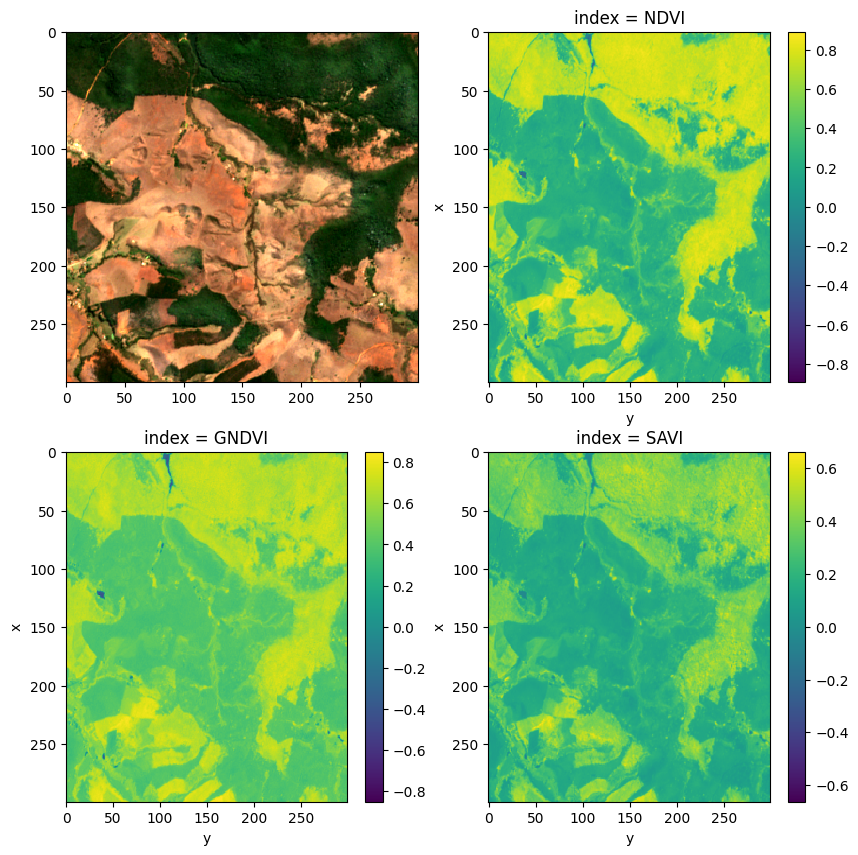

In [40]:
# Plot the indices (and the RGB image for comparison)
fig, ax = plt.subplots(2,2,figsize = (10,10))
snt.sel(band=["B04", "B03", "B02"]).plot.imshow(
    rgb="band",
    robust=True,
    add_labels=False,
    ax = ax[0,0],
    origin='upper'
)
idx.sel(index = "NDVI").plot.imshow(cmap='viridis',ax = ax[0,1], origin='upper')
idx.sel(index = "GNDVI").plot.imshow(cmap='viridis',ax = ax[1,0], origin='upper')
idx.sel(index = "SAVI").plot.imshow(cmap='viridis',ax = ax[1,1], origin='upper')

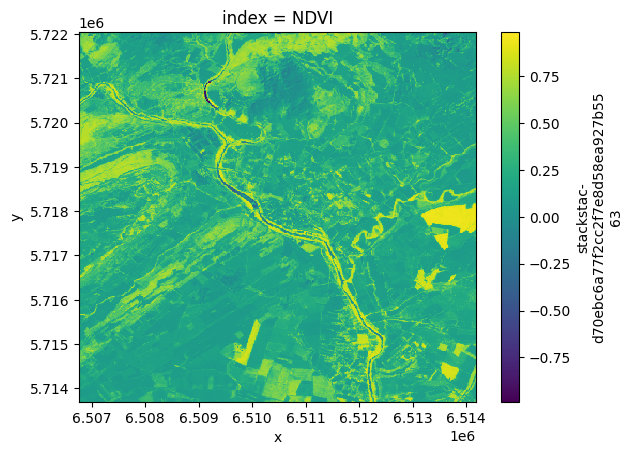

In [99]:
idx.sel(index = "NDVI").plot.imshow(cmap='viridis')

In [ ]:
def write_dataarray_to_geotiff(data_array, filename):
    # Extract the metadata from the DataArray
    meta = {
        'count': 1,  # Number of bands (assuming a single band)
        'crs': data_array.rio.crs,  # CRS from the DataArray
        'transform': data_array.rio.transform(),  # Transform from the DataArray
        'dtype': str(data_array.dtype),  # Data type
        'nodata': None,  # NoData value (optional, set to None if not needed)
    }

    # Write the DataArray to a GeoTIFF file
    with rasterio.open(filename, 'w', **meta) as dst:
        dst.write(data_array.values, 1)  # Write the data to the first band

# Assuming you have a DataArray called 'my_data_array'
write_dataarray_to_geotiff(my_data_array, 'output.tif')


In [100]:
NDVI = idx.sel(index = "NDVI")

In [101]:
NDVI_crs = R

In [104]:
NDVI_crs.data = NDVI.data

In [105]:
NDVI_crs

<xarray.DataArray 'stackstac-d70ebc6a77f2cc2f7e8d58ea927b5563' (y: 417, x: 371)>
array([[0.33492823, 0.35588235, 0.42096506, ..., 0.11013767, 0.12867133,
        0.15973378],
       [0.54285714, 0.18501171, 0.46402878, ..., 0.14901961, 0.13659706,
        0.14285714],
       [0.318236  , 0.18291055, 0.47905282, ..., 0.14245149, 0.15168317,
        0.13732787],
       ...,
       [0.17071197, 0.17580645, 0.14930808, ..., 0.21488008, 0.47384155,
        0.18745545],
       [0.20050336, 0.17370547, 0.14529915, ..., 0.24305894, 0.40218878,
        0.37359551],
       [0.2503937 , 0.15937375, 0.15630747, ..., 0.18988358, 0.44490472,
        0.4841998 ]])
Coordinates: (12/30)
    time                          datetime64[ns] 2022-09-05
    id                            <U24 'S2B_30TXN_20220905_0_L2A'
    band                          <U3 'B04'
  * x                             (x) float64 6.507e+06 6.507e+06 ... 6.514e+06
  * y                             (y) float64 5.722e+06 5.722e+06 ... 5.714e+06
    sentinel:sequence             <U1 '0'
    ...                            ...
    title                         <U14 'Band 4 (red)'
    proj:transform                object {0, 4800000, 600000, 1, 10, -10}
    common_name                   <U5 'red'
    center_wavelength             float64 0.6645
    full_width_half_max           float64 0.038
    epsg                          int64 5070
Attributes:
    spec:        RasterSpec(epsg=5070, bounds=(6506760, 5713700, 6514180, 572...
    crs:         epsg:5070
    transform:   | 20.00, 0.00, 6506760.00|\n| 0.00,-20.00, 5722040.00|\n| 0....
    resolution:  20

In [106]:
NDVI.rio.to_raster('ndvi_test.tiff')